In [1]:
# json library is used to handle json files, here, it is the data source retrieved by the perceval module.
import json 
# to write and read csv files, to show the output in the end
import csv  

# importing pandas
# pandas is used for handling huge data using dataframe
import pandas as pd

# to handle the time formats, like to determine 'created_at' of an issue or pr.
from datetime import datetime, date, timedelta

# dictionaries are a convenient way to store data for later retrieval by name (key).
from collections import defaultdict  

# it is used to send http requests, I used to get the year in which the project created to do the analysis, using requests and github api.
import requests 

import matplotlib.pyplot as plt


In [2]:
repos = ['badgeyay','phimpme-android','susi_server','susi_android','open-event-server']

ctypes = ('commit','pull_request','issue')

In [3]:
# function to get the required details of commits
# commit has a different json structure unlike issue/pr

def details_commit(commit):
    # load the commit data into the object
    data = commit['data']
    # traverse through the json line to find the required data
    content ={
            # get the hash of the commit
            'hash': data['commit'],
            # get the author_name
            'author': data['Author'],  
            # get the date at which the commit was created
            'created_date': datetime.strptime(data['CommitDate'],"%a %b %d %H:%M:%S %Y %z")  
    }
    return content

In [4]:
# function to get the required details of issue/pull requests
# as issue/pr has the same json structure in the data source scraped by perceval
# I wrote a single function to get the either issue/pr details 

def details_ipr(item):
    # load the commit data into the object
    data = item['data']
    # traverse through the json line to find the required data
    content ={
            # get the hash of the issue/pr
            'hash': data['id'],
            # get the author_name
            'author': data['user']['login'],  
            # get the date at which the issue/pr was created
            'created_date': datetime.strptime(data['created_at'],"%Y-%m-%dT%H:%M:%SZ")  
    }
    return content 

In [5]:
def getContents(repo):
    
    # intializing the content dataframe with the required details
    content_df = {
        # commit has the column >> hash, author, date
        'commit':pd.DataFrame(columns=['hash', 'author', 'created_date']),
        # issue has the column >> hash, author, date
        'issue':pd.DataFrame(columns=['hash', 'author', 'created_date']),
        # pr has the column >> hash, author, date
        'pull_request':pd.DataFrame(columns=['hash', 'author', 'created_date'])
    }

    # contents is to store the details of each contribution whether it is a commit, issue or pr.
    # using a defaultdict of list so that I can store the sorted details according to the ctype as (key, value) 
    contents = defaultdict(list)
    
    # to filter out commit, issue, pr details from the data source and store them seperately in dict.
    # loading the file into an object
    with open('../data/%s.json'%repo) as datasrc:
        for line in datasrc:
            # load the line in the json format so as to iterate to get the required results
            line = json.loads(line)
            # if it is a commit, get the details of commit
            if line['category'] == 'commit':    
                content = details_commit(line) 
            # if it is a issue, get the details of issue
            elif line['category'] == 'issue':    
                content = details_ipr(line)
            # if it is a pr, get the details of pr
            elif line['category'] == 'pull_request':    
                content = details_ipr(line) 
            # add the (key, value) to the list
            contents[line['category']].append(content)
    for item in contents:
        content_df[item]=content_df[item].append(contents[item],sort=False)
    return content_df

In [6]:
initial_date = datetime.combine(date.today() - timedelta(3*365/12), datetime.min.time())   # convert datetime.date to datetime.datetime

In [7]:
repodata = defaultdict(list)

for repo in repos:
    repo_df = getContents(repo)
    total = 0
    for ctype in ctypes:
        df = repo_df[ctype]
        df['created_date']= df['created_date'].apply(lambda x:x.replace(tzinfo=None))
        df = df[df['created_date'] >= initial_date]
        repodata[ctype].append(df['hash'].nunique())

In [8]:
print("Repositories Details in the past three months\n")
for item in dict(repodata):
    # print the total activity quaterly
    print (item, dict(repodata)[item])  

Repositories Details in the past three months

commit [102, 153, 37, 78, 147]
pull_request [64, 0, 18, 140, 123]
issue [0, 345, 32, 262, 231]


In [9]:
qinfo = pd.DataFrame()
qinfo['Repository'] = repos
qinfo['# Commits'] = repodata['commit']
qinfo['# Issues'] = repodata['issue']
qinfo['# PullRequests'] = repodata['pull_request']
qinfo["# Total"] =qinfo.sum(axis=1)

In [10]:
qinfo.to_csv('result.csv',index=None)

In [11]:
pd.read_csv('result.csv')

,Repository,# Commits,# Issues,# PullRequests,# Total
0,badgeyay,102,0,64,166
1,phimpme-android,153,345,0,498
2,susi_server,37,32,18,87
3,susi_android,78,262,140,480
4,open-event-server,147,231,123,501


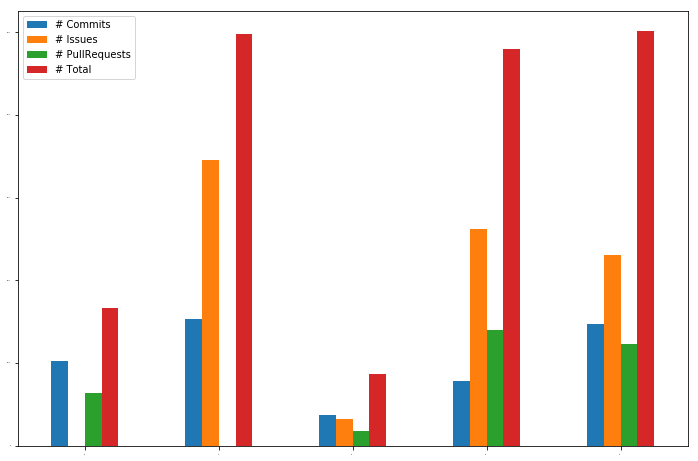

In [13]:
df2 = pd.DataFrame(qinfo, columns=['# Commits', '# Issues', '# PullRequests', '# Total'])
df2.plot.bar(figsize=(12,8));